
### [A Neural Probabilistic Language Model](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf) - BENGIO, DUCHARME, VINCENT AND JAUVIN (2003)

---

In [13]:
import torch
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
random.seed(42)

In [15]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [16]:
len(words)

32033

In [17]:
# Build the vocabulary of characters and mapping to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [18]:
block_size = 3  # Context length: How many characters do we take to predict the next one.

In [19]:
def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]  # Crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

In [20]:
random.shuffle(words)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [21]:
# 4-dimensional exammple of initialization problem
# logits = torch.tensor([0.0, 0.0, 0.0, 0.0]) # Even distribution
# logits = torch.tensor([0.0, 0.0, 2.0, 0.0]) # Correct value
# logits = torch.tensor([0.0, 8.0, 0.0, 0.0]) # Incorrect value
logits = torch.rand(4) * 10 # Random Distribution
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
logits, probs, loss

(tensor([3.0973, 8.7498, 9.6479, 2.6218]),
 tensor([1.0139e-03, 2.8898e-01, 7.0937e-01, 6.3020e-04]),
 tensor(0.3434))

In [22]:
# Estimate the initial loss value - Negative log of the probability distribution
-torch.tensor(1/vocab_size).log()

tensor(3.2958)

In [23]:
# Initialize model

n_embd = 10         # The dimensionality of the character embedding vectors
n_hidden = 200      # The number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483642)
C = torch.randn((vocab_size, n_embd), generator=g)

# Model
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),             generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.2
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # Total number of parameters

for p in parameters:
    p.requires_grad = True

11897


In [24]:
epochs = 200000
batch_size = 32
lossi = []

for i in range(epochs):

    # Minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # Batch X, Y

    # Forward pass
    emb = C[Xb] # Embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # Concatenate the vectos
    hpreact = embcat @ W1 + b1 # Hidden layer pre-activation
    h = torch.tanh(hpreact) # Hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Ytr[ix]) # Loss function
    
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update
    lr = 0.1 if i < 100000 else 0.01 # Step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # # Metrics
    if i % 10000 == 0:
        print(f'{i:7d} / {epochs:7d}: {loss.item():4f}')

    lossi.append(loss.log10().item())
    

      0 /  200000: 3.313459
  10000 /  200000: 2.164827
  20000 /  200000: 2.306087
  30000 /  200000: 2.454140
  40000 /  200000: 1.978677
  50000 /  200000: 2.292970
  60000 /  200000: 2.423235
  70000 /  200000: 2.067997
  80000 /  200000: 2.309544
  90000 /  200000: 2.120709
 100000 /  200000: 1.826862
 110000 /  200000: 2.204485
 120000 /  200000: 1.979655
 130000 /  200000: 2.394565
 140000 /  200000: 2.100045
 150000 /  200000: 2.194801
 160000 /  200000: 1.861940
 170000 /  200000: 1.780916
 180000 /  200000: 1.967284
 190000 /  200000: 1.829463


torch.Size([32, 200])


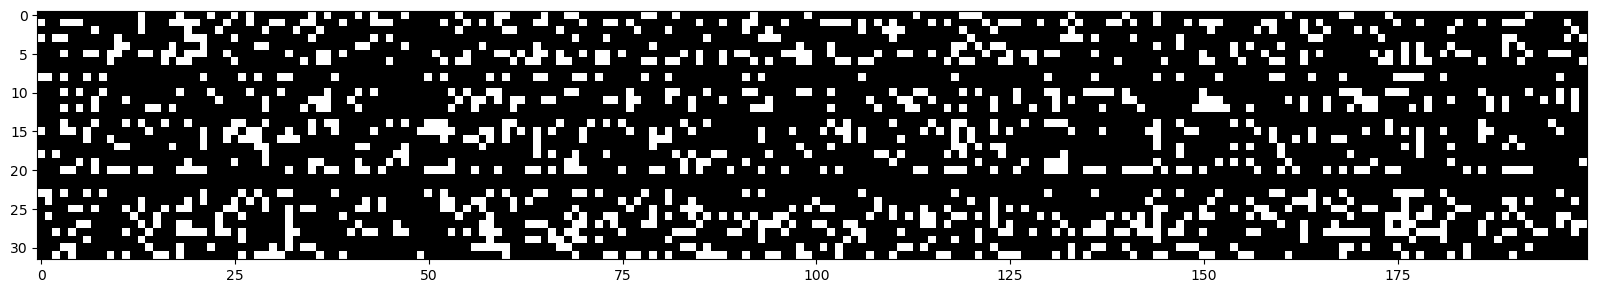

In [25]:
# Vizualize neurons in the tanh hidden layer - 32 examples (batch size) across 200 neurons
print(h.shape)
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

In [ ]:
plt.hist(h.view(-1).tolist(), 50);

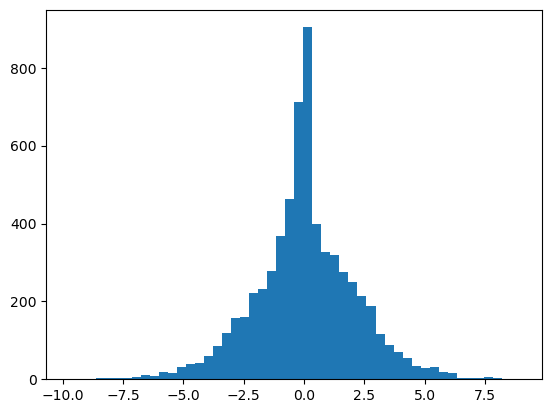

In [26]:
plt.hist(hpreact.view(-1).tolist(), 50);

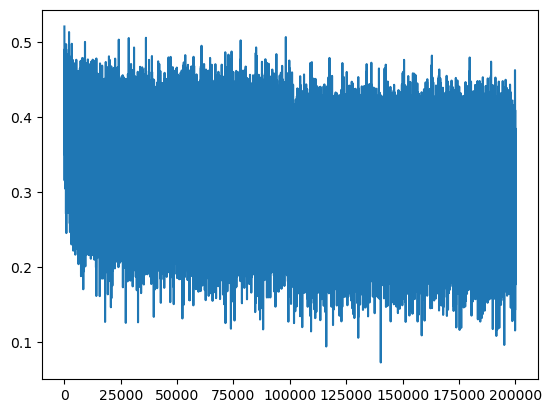

In [27]:
plt.plot(lossi) # Use lri when identifing learning rate

In [28]:
@torch.no_grad() # This decorator disables gradient tracking
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]

    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # Concat into (N, block_size * nembd)
    h = torch.tanh(embcat @ W1 + b1) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())


In [29]:
split_loss('train')
split_loss('val')

train 2.0355966091156006
val 2.1026785373687744


In [30]:
# Sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # Initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      # Sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # Shift the context window to track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # If we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # Decode and print the generated word

carmahzauri.
jai.
kimri.
reh.
casparsha.
jazhith.
deliah.
jareei.
nellara.
chaily.
kaleigh.
ham.
jorn.
quint.
salin.
alianni.
waythoniearyn.
kai.
euliyuan.
eddeli.
